Exemplo de uma CNN para reconhecer meses do ano. 

In [11]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from PIL import Image
import numpy as np
import cv2
from sklearn.metrics import confusion_matrix
import progressbar

Carrega a base de dados. Os arquivos train.txt e test.txt contêm os nomes dos arquivos e os labels das imagens que estão dentro do diretório ./data

Note que as imagens precisam ser normalizadas para a entrada da rede neural. Nesse caso, elas estão sendo normalizadas em 64x64. 


---



In [12]:
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

train_file = '/home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/train.txt'
test_file = '/home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/test.txt'
# input image dimensions
img_rows, img_cols = 64, 64
num_classes = 12


def load_images(image_paths, convert=False):

  x = []
  y = []

  for image_path in progressbar.progressbar(image_paths):
    path, label = image_path.split(' ')
    path= '/home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/' + path
    
    
    if convert:
      image_pil = Image.open(path).convert('RGB') 
    else:
      image_pil = Image.open(path).convert('L')

    img = np.array(image_pil, dtype=np.uint8)

    x.append(img)
    y.append([int(label)])
    
  x = np.array(x)
  y = np.array(y)

  if np.min(y) != 0: 
    y = y-1

  return x, y
	

def load_dataset(train_file, test_file, resize, convert=False, size=(224,224)):
  arq = open(train_file, 'r')
  texto = arq.read()
  train_paths = texto.split('\n')
	
  print ('Size : ', size )

  train_paths.remove('') #remove empty lines
  train_paths.sort()

  x_train, y_train = load_images(train_paths, convert)

  arq = open(test_file, 'r')
  texto = arq.read()
  test_paths = texto.split('\n')

  test_paths.remove('') #remove empty lines
  test_paths.sort()
  x_test, y_test = load_images(test_paths, convert)
  
  if resize:
    print ("Resizing images...")
    x_train = resize_data(x_train, size, convert)
    x_test = resize_data(x_test, size, convert)

  if not convert:
    x_train = x_train.reshape(x_train.shape[0], size[0], size[1], 1)
    x_test = x_test.reshape(x_test.shape[0], size[0], size[1], 1)


  print (np.shape(x_train))
  return (x_train, y_train), (x_test, y_test)

###### Resize data
def resize_data(data, size, convert):

  if convert:
    data_upscaled = np.zeros((data.shape[0], size[0], size[1], 3))
  else:
    data_upscaled = np.zeros((data.shape[0], size[0], size[1]))

  for i, img in enumerate(data):
    large_img = cv2.resize(img, dsize=(size[1], size[0]), interpolation=cv2.INTER_CUBIC)
    data_upscaled[i] = large_img

  print (np.shape(data_upscaled))
  return data_upscaled


# rgb
input_shape = (img_rows, img_cols, 3)
(x_train, y_train), (x_test, y_test) = load_dataset(train_file, test_file, resize=True, convert=True, size=(img_rows, img_cols))

### save for the confusion matrix
label = []
for i in range(len(x_test)):
	label.append(y_test[i][0])
	

print ('Normalizing images...')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print ('x_train shape:', x_train.shape)

print (x_train.shape[0], 'train samples')
print (x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

# data augmentation
datagen = ImageDataGenerator(rotation_range=15, zoom_range=0.25)
datagen.fit(x_train)

 10% (160 of 1578) |##                   | Elapsed Time: 0:00:00 ETA:   0:00:01

Size :  (64, 64)


100% (1578 of 1578) |####################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (401 of 401) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Resizing images...
(1578, 64, 64, 3)
(401, 64, 64, 3)
(1578, 64, 64, 3)
Normalizing images...
x_train shape: (1578, 64, 64, 3)
1578 train samples
401 test samples


Treina a rede neural com três camada de convolução.

---



In [13]:
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization

model = Sequential()

def model_6_layers():
    model.add(Conv2D(32, 3, 3, input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(64, 3, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, 5, 5))
    model.add(Activation('relu'))
    model.add(Conv2D(256, 5, 5))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.30))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

model_6_layers()

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adadelta(lr=1.0, rho=0.95), metrics=['accuracy'])


#model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])

#model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test))

model.fit_generator(datagen.flow(x_train, y_train, batch_size=64), 
                    samples_per_epoch=x_train.shape[0],
                    nb_epoch=110, validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print ('Test loss:', score[0])
print ('Test accuracy:', score[1])

#print model.predict_classes(x_test) #classes predicted
#print model.predict_proba(x_test) #classes probability

pred = []
y_pred = model.predict_classes(x_test)
for i in range(len(x_test)):
	pred.append(y_pred[i])

print(confusion_matrix(label, pred))


/home/nakayama/anaconda3/envs/Trabalho_CNN/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(64, 64, 3...)`
  import sys
/home/nakayama/anaconda3/envs/Trabalho_CNN/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
  if __name__ == '__main__':
/home/nakayama/anaconda3/envs/Trabalho_CNN/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (5, 5))`
  
/home/nakayama/anaconda3/envs/Trabalho_CNN/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (5, 5))`
  app.launch_new_instance()
/home/nakayama/anaconda3/envs/Trabalho_CNN/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Ker

Epoch 1/110
24/24 [==============================] - 16s 653ms/step - loss: 2.7094 - acc: 0.1504 - val_loss: 2.0739 - val_acc: 0.3042
Epoch 2/110
24/24 [==============================] - 16s 664ms/step - loss: 2.0248 - acc: 0.3247 - val_loss: 1.7371 - val_acc: 0.4264
Epoch 3/110
24/24 [==============================] - 17s 694ms/step - loss: 1.6268 - acc: 0.4726 - val_loss: 1.1422 - val_acc: 0.6633
Epoch 4/110
24/24 [==============================] - 18s 770ms/step - loss: 1.3070 - acc: 0.5691 - val_loss: 1.0385 - val_acc: 0.6534
Epoch 5/110
24/24 [==============================] - 18s 753ms/step - loss: 1.1869 - acc: 0.6075 - val_loss: 2.0204 - val_acc: 0.4888
Epoch 6/110
24/24 [==============================] - 18s 762ms/step - loss: 1.0698 - acc: 0.6629 - val_loss: 1.0755 - val_acc: 0.6883
Epoch 7/110
24/24 [==============================] - 19s 778ms/step - loss: 0.9325 - acc: 0.6860 - val_loss: 2.5931 - val_acc: 0.4788
Epoch 8/110
24/24 [==============================] - 18s 762ms

Epoch 62/110
24/24 [==============================] - 17s 708ms/step - loss: 0.0801 - acc: 0.9739 - val_loss: 0.2337 - val_acc: 0.9476
Epoch 63/110
24/24 [==============================] - 16s 687ms/step - loss: 0.0768 - acc: 0.9746 - val_loss: 0.4447 - val_acc: 0.8928
Epoch 64/110
24/24 [==============================] - 16s 683ms/step - loss: 0.1014 - acc: 0.9665 - val_loss: 0.3109 - val_acc: 0.9352
Epoch 65/110
24/24 [==============================] - 16s 683ms/step - loss: 0.0772 - acc: 0.9756 - val_loss: 0.3991 - val_acc: 0.8978
Epoch 66/110
24/24 [==============================] - 17s 688ms/step - loss: 0.0810 - acc: 0.9756 - val_loss: 0.7801 - val_acc: 0.8304
Epoch 67/110
24/24 [==============================] - 16s 678ms/step - loss: 0.1029 - acc: 0.9704 - val_loss: 0.2893 - val_acc: 0.9277
Epoch 68/110
24/24 [==============================] - 17s 688ms/step - loss: 0.1104 - acc: 0.9651 - val_loss: 0.2651 - val_acc: 0.9327
Epoch 69/110
24/24 [==============================] - 1

Mostra as imagens com erro.

/home/nakayama/anaconda3/envs/Trabalho_CNN/lib/python3.7/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets
100% (401 of 401) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


7
Label: agosto  | Prediction: maio /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/AD1335.jpg


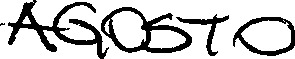

35
Label: fevereiro  | Prediction: janeiro /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0056.jpg


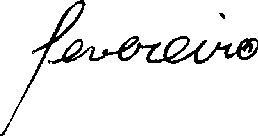

51
Label: abril  | Prediction: agosto /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0119.jpg


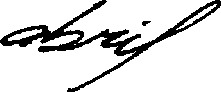

65
Label: setembro  | Prediction: novembro /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0251.jpg


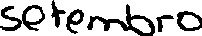

67
Label: setembro  | Prediction: novembro /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0254.jpg


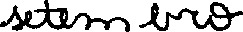

81
Label: setembro  | Prediction: dezembro /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0269.jpg


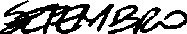

84
Label: setembro  | Prediction: dezembro /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0272.jpg


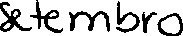

143
Label: dezembro  | Prediction: novembro /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0339.jpg


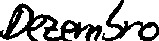

146
Label: dezembro  | Prediction: novembro /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0342.jpg


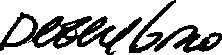

152
Label: dezembro  | Prediction: junho /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0348.jpg


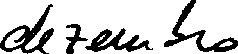

188
Label: janeiro  | Prediction: fevereiro /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0386.jpg


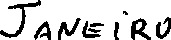

213
Label: fevereiro  | Prediction: novembro /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0412.jpg


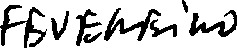

216
Label: fevereiro  | Prediction: janeiro /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0416.jpg


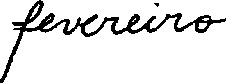

254
Label: marco  | Prediction: maio /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0454.jpg


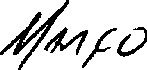

296
Label: maio  | Prediction: abril /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0496.jpg


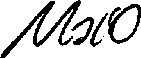

301
Label: maio  | Prediction: abril /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0501.jpg


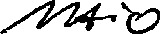

316
Label: junho  | Prediction: julho /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0518.jpg


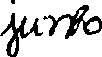

323
Label: junho  | Prediction: janeiro /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0525.jpg


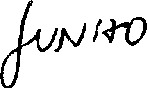

334
Label: junho  | Prediction: julho /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0536.jpg


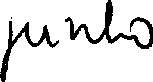

394
Label: dezembro  | Prediction: novembro /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0702.jpg


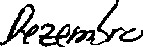

In [15]:
###############################################################################
# Show confusions
###############################################################################
meses = ['janeiro', 'fevereiro', 'marco', 'abril', 'maio', 'junho', 'julho', 'agosto', 'setembro', 'outubro', 'novembro', 'dezembro']

from google.colab.patches import cv2_imshow

arq = open(test_file, 'r')
texto = arq.read()
test_paths = texto.split('\n')

test_paths.remove('') #remove empty lines
test_paths.sort()

images =[]
labels = []

for image_path in progressbar.progressbar(test_paths):
  path, label = image_path.split(' ')
  path= '/home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/' + path
  
  images.append(path)
  labels.append(int(label))
    

for i in range(len(y_pred)):

  ## Erro...
  if (y_pred[i] != labels[i]):
    print (i)
      
    print("Label:", meses[labels[i]], " | Prediction:", meses[y_pred[i]], images[i] )
    im=cv2.imread(images[i])
    cv2_imshow(im)